In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
from data.data_utils import *
from atl_utils import *
from copy import deepcopy
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [2]:
### Load arrays
X_desc = joblib.load("./joblib_files/X_desc.joblib")
X_id = joblib.load("./joblib_files/X_id.joblib")
y = joblib.load("./joblib_files/y.joblib")
desc_names = joblib.load("./joblib_files/desc_names.joblib")

In [3]:
# Training source model after removing ProIndan data
X_candidate_desc = prep_array_of_enumerated_candidates([Ni_source_onehot, ligand_desc, additive_ion_onehot, solvent_desc])
BocAla = pd.read_excel("./data/descriptors.xlsx", sheet_name="NHPI", usecols=list(np.arange(2,14))).to_numpy()[1,:]
IndanKat = pd.read_excel("./data/descriptors.xlsx", sheet_name="Katritzky", usecols=list(np.arange(2,14))).to_numpy()[1,:]

X_candidate_desc = np.hstack((
    np.hstack((BocAla, IndanKat)).reshape(1,-1).repeat(X_candidate_desc.shape[0], axis=0),
    X_candidate_desc
))
print(X_candidate_desc.shape)

(18270, 58)


In [4]:
# Separating the 80 reactions between BocAla and Indan in the original dataset
X_desc_noAlaIndan, X_desc_AlaIndan = X_desc[:-80, :], X_desc[-80:,:]
X_id_noAlaIndan, X_id_AlaIndan = X_id[:-80,:], X_id[-80:, :]
print(X_id_noAlaIndan.shape)
y_noAlaIndan, y_AlaIndan = y[:-80], y[-80:]

(83, 8)


In [5]:
target_AlaIndan_models_15_trees = train_target_models(X_desc_AlaIndan, y_AlaIndan, 100, 15, max_depth=1)

In [6]:
# Removing the 80 that has been tested as a part of the source data from all possible candidates
X_candidate_id = prep_array_of_enumerated_candidates(COMPONENT_ID_ARRAY)
X_candidate_desc = id_array_to_desc_array(
    np.hstack((
        np.ones(X_candidate_id.shape[0]).reshape(-1, 1),
        np.ones(X_candidate_id.shape[0]).reshape(-1, 1)*2,
        X_candidate_id
    )),
    True
)
print(X_candidate_id.shape, X_candidate_desc.shape)

initial_X_candidate_id, initial_X_candidate_desc = remove_prev_sampled_rxns(
    X_candidate_id, X_candidate_desc, X_id_AlaIndan[:, 2:-1]
)
print(initial_X_candidate_id.shape, initial_X_candidate_desc.shape)

(18270, 5) (18270, 58)
(18199, 5) (18199, 58)


In [7]:
# Adding ProMex reactions
ProMex_data = sheets_to_list_of_dfs("./data/reaction_data.xlsx", ["ProMex"])
X_id_ProMex = ProMex_data[0].iloc[:, 1:-2].to_numpy()
X_desc_ProMex = id_array_to_desc_array(X_id_ProMex, True)

LCyield_ProMex = ProMex_data[0].iloc[:, -1].to_numpy()
y_ProMex = np.zeros_like(LCyield_ProMex)
y_ProMex[np.where(LCyield_ProMex < 7)[0]] = 0
y_ProMex[np.where(LCyield_ProMex >= 7)[0]] = 1

# Following what was actually done
X_ATL_desc_source = np.vstack((X_desc[:-80], X_desc_ProMex, X_desc[-80:])) 
y_ATL_source = np.concatenate((y[:-80], y_ProMex, y[-80:]))
print(X_ATL_desc_source.shape, y_ATL_source.shape)

(235, 58) (235,)


In [8]:
# Training source model
ATL_source_model_100_trees = []
for j in range(100) :
    rfc = RandomForestClassifier(n_estimators=100, max_depth=1, random_state=42+j, n_jobs=-1)
    rfc.fit(X_ATL_desc_source, y_ATL_source)
    ATL_source_model_100_trees.append(rfc)

In [9]:
# Copying the ID arrays to separate from the AL approach
initial_ATL_X_candidate_desc = deepcopy(initial_X_candidate_desc)
initial_ATL_X_candidate_id = deepcopy(initial_X_candidate_id)

In [10]:
first_combined_ATL_model = combine_two_model_list_shuffled(ATL_source_model_100_trees, target_AlaIndan_models_15_trees)

# Suggestions from 100 trees with 12 votes
count_list = count_num_topN_suggestions(
    [first_combined_ATL_model], 
    initial_ATL_X_candidate_desc, 
    12
)
print_suggestions(initial_ATL_X_candidate_id, count_list[0], 24)

[NiBr2(glyme),  4CF3,                    KBr,                      THF] 61
[NiBr2(glyme),  4CF3,                    KBr,                  Dioxane] 58
[NiCl2(glyme),  4CF3,                    KBr,                  Dioxane] 57
[    Ni(COD)2,  4CF3,                    KBr,                      THF] 54
[        NiI2,  4CF3,                    KBr,                      THF] 50
[        NiI2,  4CF3,                    KBr,                  Dioxane] 49
[    Ni(COD)2,  4CF3,                    KBr,                  Dioxane] 45
[   Ni(acac)2,  4CF3,                    KBr,                      THF] 44
[NiCl2(glyme),  4CF3,                    KCl,                      THF] 38
[NiBr2(glyme),  4CF3,                    KCl,                      THF] 35
[   Ni(acac)2,  4CF3,                    KBr,                  Dioxane] 33
[NiCl2(glyme),  4CF3,                    KCl,                  Dioxane] 26
[NiBr2(glyme),  4CF3,                    KCl,                  Dioxane] 22
[        NiI2,  4CF3,    

## Second iteration

In [11]:
### Array preparation
df1 = sheets_to_list_of_dfs("./data/reaction_data.xlsx", ["AlaIndan_ATL"])
ATL_first_id_array = df1[0].iloc[:6, 1:-2].to_numpy()
AlaIndan_ATL_first_desc = id_array_to_desc_array(ATL_first_id_array, True)

ATL_first_assay_yield = df1[0].iloc[:6, -1].to_numpy()
y_ATL_first = np.zeros(len(ATL_first_assay_yield))
y_ATL_first[np.where(ATL_first_assay_yield >= 14)[0]] = 1 
print(y_ATL_first)

[1. 0. 0. 1. 0. 0.]


In [12]:
first_ATL_target_models = train_target_models(AlaIndan_ATL_first_desc, y_ATL_first, 100, 15, max_depth=1)
first_combined_ATL_models = combine_two_model_list_shuffled(first_combined_ATL_model, first_ATL_target_models)

In [13]:
# Removing the reactions conducted in first iteration
print("Before removing previous samples: ", initial_ATL_X_candidate_id.shape, initial_ATL_X_candidate_desc.shape)
ATL_X_candidate_id, ATL_X_candidate_desc = remove_prev_sampled_rxns(
    initial_ATL_X_candidate_id, initial_ATL_X_candidate_desc, ATL_first_id_array[:, 2:]
)
print("After removing previous samples: ", ATL_X_candidate_id.shape, ATL_X_candidate_desc.shape)

Before removing previous samples:  (18199, 5) (18199, 58)
After removing previous samples:  (18193, 5) (18193, 58)


In [14]:
# Suggestions from 100 trees with 12 votes
count_list = count_num_topN_suggestions(
    [first_combined_ATL_models], 
    ATL_X_candidate_desc, 
    12
)
print_suggestions(ATL_X_candidate_id, count_list[0], 24)

[        NiI2,  4CF3,                    KBr,                  Dioxane] 87
[        NiI2,  4CF3,                    KCl,                  Dioxane] 77
[        NiI2,  4CF3,                     KI,                  Dioxane] 64
[        NiI2,  4CF3,                  MgBr2,                  Dioxane] 63
[        NiI2,  4CF3,                  TBABr,                  Dioxane] 63
[NiCl2(glyme),  4CF3,                    KCl,                  Dioxane] 58
[NiCl2(glyme),  4CF3,                     KI,                  Dioxane] 51
[NiCl2(glyme),  4CF3,                  MgBr2,                  Dioxane] 49
[NiCl2(glyme),  4CF3,                  TBABr,                  Dioxane] 47
[        NiI2,  4CF3,            succinimide,                  Dioxane] 42
[        NiI2,  4CF3,                  MgCl2,                  Dioxane] 41
[        NiI2,  4CF3,                  ZnCl2,                  Dioxane] 41
[        NiI2,  4CF3,                  TMSCl,                  Dioxane] 39
[        NiI2,  4CF3,    

## Third iteration

In [15]:
### Array preparation
df1 = sheets_to_list_of_dfs("./data/reaction_data.xlsx", ["AlaIndan_ATL"])
ATL_second_id_array = df1[0].iloc[6:12, 1:-2].to_numpy()
AlaIndan_ATL_second_desc = id_array_to_desc_array(ATL_second_id_array, True)

ATL_second_assay_yield = df1[0].iloc[6:12, -1].to_numpy()
y_ATL_second = np.zeros(len(ATL_second_assay_yield))
y_ATL_second[np.where(ATL_second_assay_yield >= 14)[0]] = 1 
print(y_ATL_second)

[1. 0. 0. 1. 0. 1.]


In [16]:
second_ATL_target_models = train_target_models(AlaIndan_ATL_second_desc, y_ATL_second, 100, 15, max_depth=1)
second_combined_ATL_models = combine_two_model_list_shuffled(first_combined_ATL_models, second_ATL_target_models)

In [17]:
# Removing the reactions conducted in second iteration
print("Before removing previous samples: ", ATL_X_candidate_id.shape, ATL_X_candidate_desc.shape)
ATL_X_candidate_id, ATL_X_candidate_desc = remove_prev_sampled_rxns(
    ATL_X_candidate_id, ATL_X_candidate_desc, ATL_second_id_array[:, 2:]
)
print("After removing previous samples: ", ATL_X_candidate_id.shape, ATL_X_candidate_desc.shape)

Before removing previous samples:  (18193, 5) (18193, 58)
After removing previous samples:  (18187, 5) (18187, 58)


In [18]:
# Suggestions from 100 trees with 12 votes
count_list = count_num_topN_suggestions(
    [second_combined_ATL_models], 
    ATL_X_candidate_desc, 
    12
)
print_suggestions(ATL_X_candidate_id, count_list[0], 24)

[NiCl2(glyme),  4CF3,                     KI,                  Dioxane] 88
[NiCl2(glyme),  4CF3,                  MgBr2,                  Dioxane] 67
[NiCl2(glyme),  4CF3,                   TBAI,                  Dioxane] 46
[NiCl2(glyme),  4CF3,                   NaCl,                  Dioxane] 44
[        NiI2,  4CF3,                  MgCl2,                  Dioxane] 41
[NiCl2(glyme),  4CF3,                     KI,                     CPME] 30
[NiCl2(glyme),  4CF3,                     KI,                      THF] 28
[        NiI2,  4CF3,                    NaI,                  Dioxane] 25
[NiCl2(glyme),  4CF3,                  MgCl2,                     CPME] 24
[NiCl2(glyme),  4CF3,                     KI,                    glyme] 24
[    Ni(COD)2,  4CF3,                     KI,                  Dioxane] 23
[NiCl2(glyme),  4CF3,                  TBACl,                  Dioxane] 23
[   Ni(acac)2,  4CF3,                     KI,                  Dioxane] 21
[    Ni(COD)2,  4CF3,    

## Model Analysis

In [19]:
source_desc_utilized = get_descriptors_used_by_target_models(ATL_source_model_100_trees, desc_names)
first_desc_utilized = get_descriptors_used_by_target_models(target_AlaIndan_models_15_trees, desc_names)
second_desc_utilized = get_descriptors_used_by_target_models(first_ATL_target_models, desc_names)
third_desc_utilized = get_descriptors_used_by_target_models(second_ATL_target_models, desc_names)
desc_utilized_by_batch = [source_desc_utilized, first_desc_utilized, second_desc_utilized, third_desc_utilized]

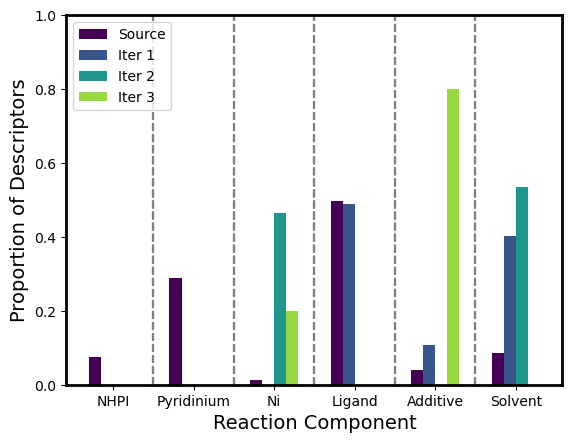

In [20]:
desc_index = [desc_names.index('Katritzky E_red'), desc_names.index('NiCl2'), desc_names.index('Ligand Ni-X'), desc_names.index('Cl'), desc_names.index('Solvent HansenD')]
prev_ind = 0
position = [-1.5, -0.5, 0.5, 1.5]
width = 0.15
bar_colors = ["#440154", "#39568C", "#1F968B", "#95D840"]
bar_labels = ["Source", "Iter 1", "Iter 2", "Iter 3"]
component_names = ["NHPI", "Pyridinium", "Ni", "Ligand", "Additive", "Solvent"]

fig, ax = plt.subplots()
for i, desc_batch in enumerate(desc_utilized_by_batch) : 
    bars = []
    bar_x_pos = [x + position[i]*width for x in range(len(desc_index)+1)] 
    for j, div_ind in enumerate(desc_index):
        bars.append(sum(desc_batch[prev_ind:div_ind])/sum(desc_batch))
        if j == len(desc_index) - 1:
            bars.append(sum(desc_batch[div_ind:])/sum(desc_batch))
        ax.axvline(j+0.5, 0, 1, ls="--", c='grey')
        prev_ind = div_ind 
    ax.bar(bar_x_pos, bars, label=bar_labels[i], color=[bar_colors[i]]*len(bars), width=width, )
ax.set_xticks(np.arange(6))
ax.set_xticklabels(component_names)
ax.set_xlabel("Reaction Component", fontsize=14)
ax.set_ylim([0,1])
ax.set_yticks(0.2*np.arange(6))
ax.set_ylabel("Proportion of Descriptors", fontsize=14)
ax.set_yticklabels([round(0.2*x, 1) for x in np.arange(6)])

ax.legend(loc="upper left")
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)